<a href="https://www.kaggle.com/code/aliniazi3/spotcancerai?scriptVersionId=247021198" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ham10000-dataset/HAM10000_folders/mel/ISIC_0028582.jpg
/kaggle/input/ham10000-dataset/HAM10000_folders/mel/ISIC_0027742.jpg
/kaggle/input/ham10000-dataset/HAM10000_folders/mel/ISIC_0030032.jpg
/kaggle/input/ham10000-dataset/HAM10000_folders/mel/ISIC_0031479.jpg
/kaggle/input/ham10000-dataset/HAM10000_folders/mel/ISIC_0033624.jpg
/kaggle/input/ham10000-dataset/HAM10000_folders/mel/ISIC_0033152.jpg
/kaggle/input/ham10000-dataset/HAM10000_folders/mel/ISIC_0031417.jpg
/kaggle/input/ham10000-dataset/HAM10000_folders/mel/ISIC_0025611.jpg
/kaggle/input/ham10000-dataset/HAM10000_folders/mel/ISIC_0026352.jpg
/kaggle/input/ham10000-dataset/HAM10000_folders/mel/ISIC_0026239.jpg
/kaggle/input/ham10000-dataset/HAM10000_folders/mel/ISIC_0033239.jpg
/kaggle/input/ham10000-dataset/HAM10000_folders/mel/ISIC_0028075.jpg
/kaggle/input/ham10000-dataset/HAM10000_folders/mel/ISIC_0028520.jpg
/kaggle/input/ham10000-dataset/HAM10000_folders/mel/ISIC_0033878.jpg
/kaggle/input/ham10000-dataset/HAM


# **Importing Libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.express as px
import os
import itertools
import cv2
from sklearn.impute import SimpleImputer

from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
#from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# **DATA READING**

In [3]:
import os

dataset_path = "/kaggle/input/ham10000-dataset/HAM10000_folders"

class_names = sorted(os.listdir(dataset_path))
print("Classes:", class_names)
print("Number of classes:", len(class_names))


Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Number of classes: 7


# **DATA Preprocessing**

**Creating dictionary for displaying more human-friendly labels.**

In [4]:

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}


base_skin_dir = '/kaggle/input/ham10000-dataset/HAM10000_folders'

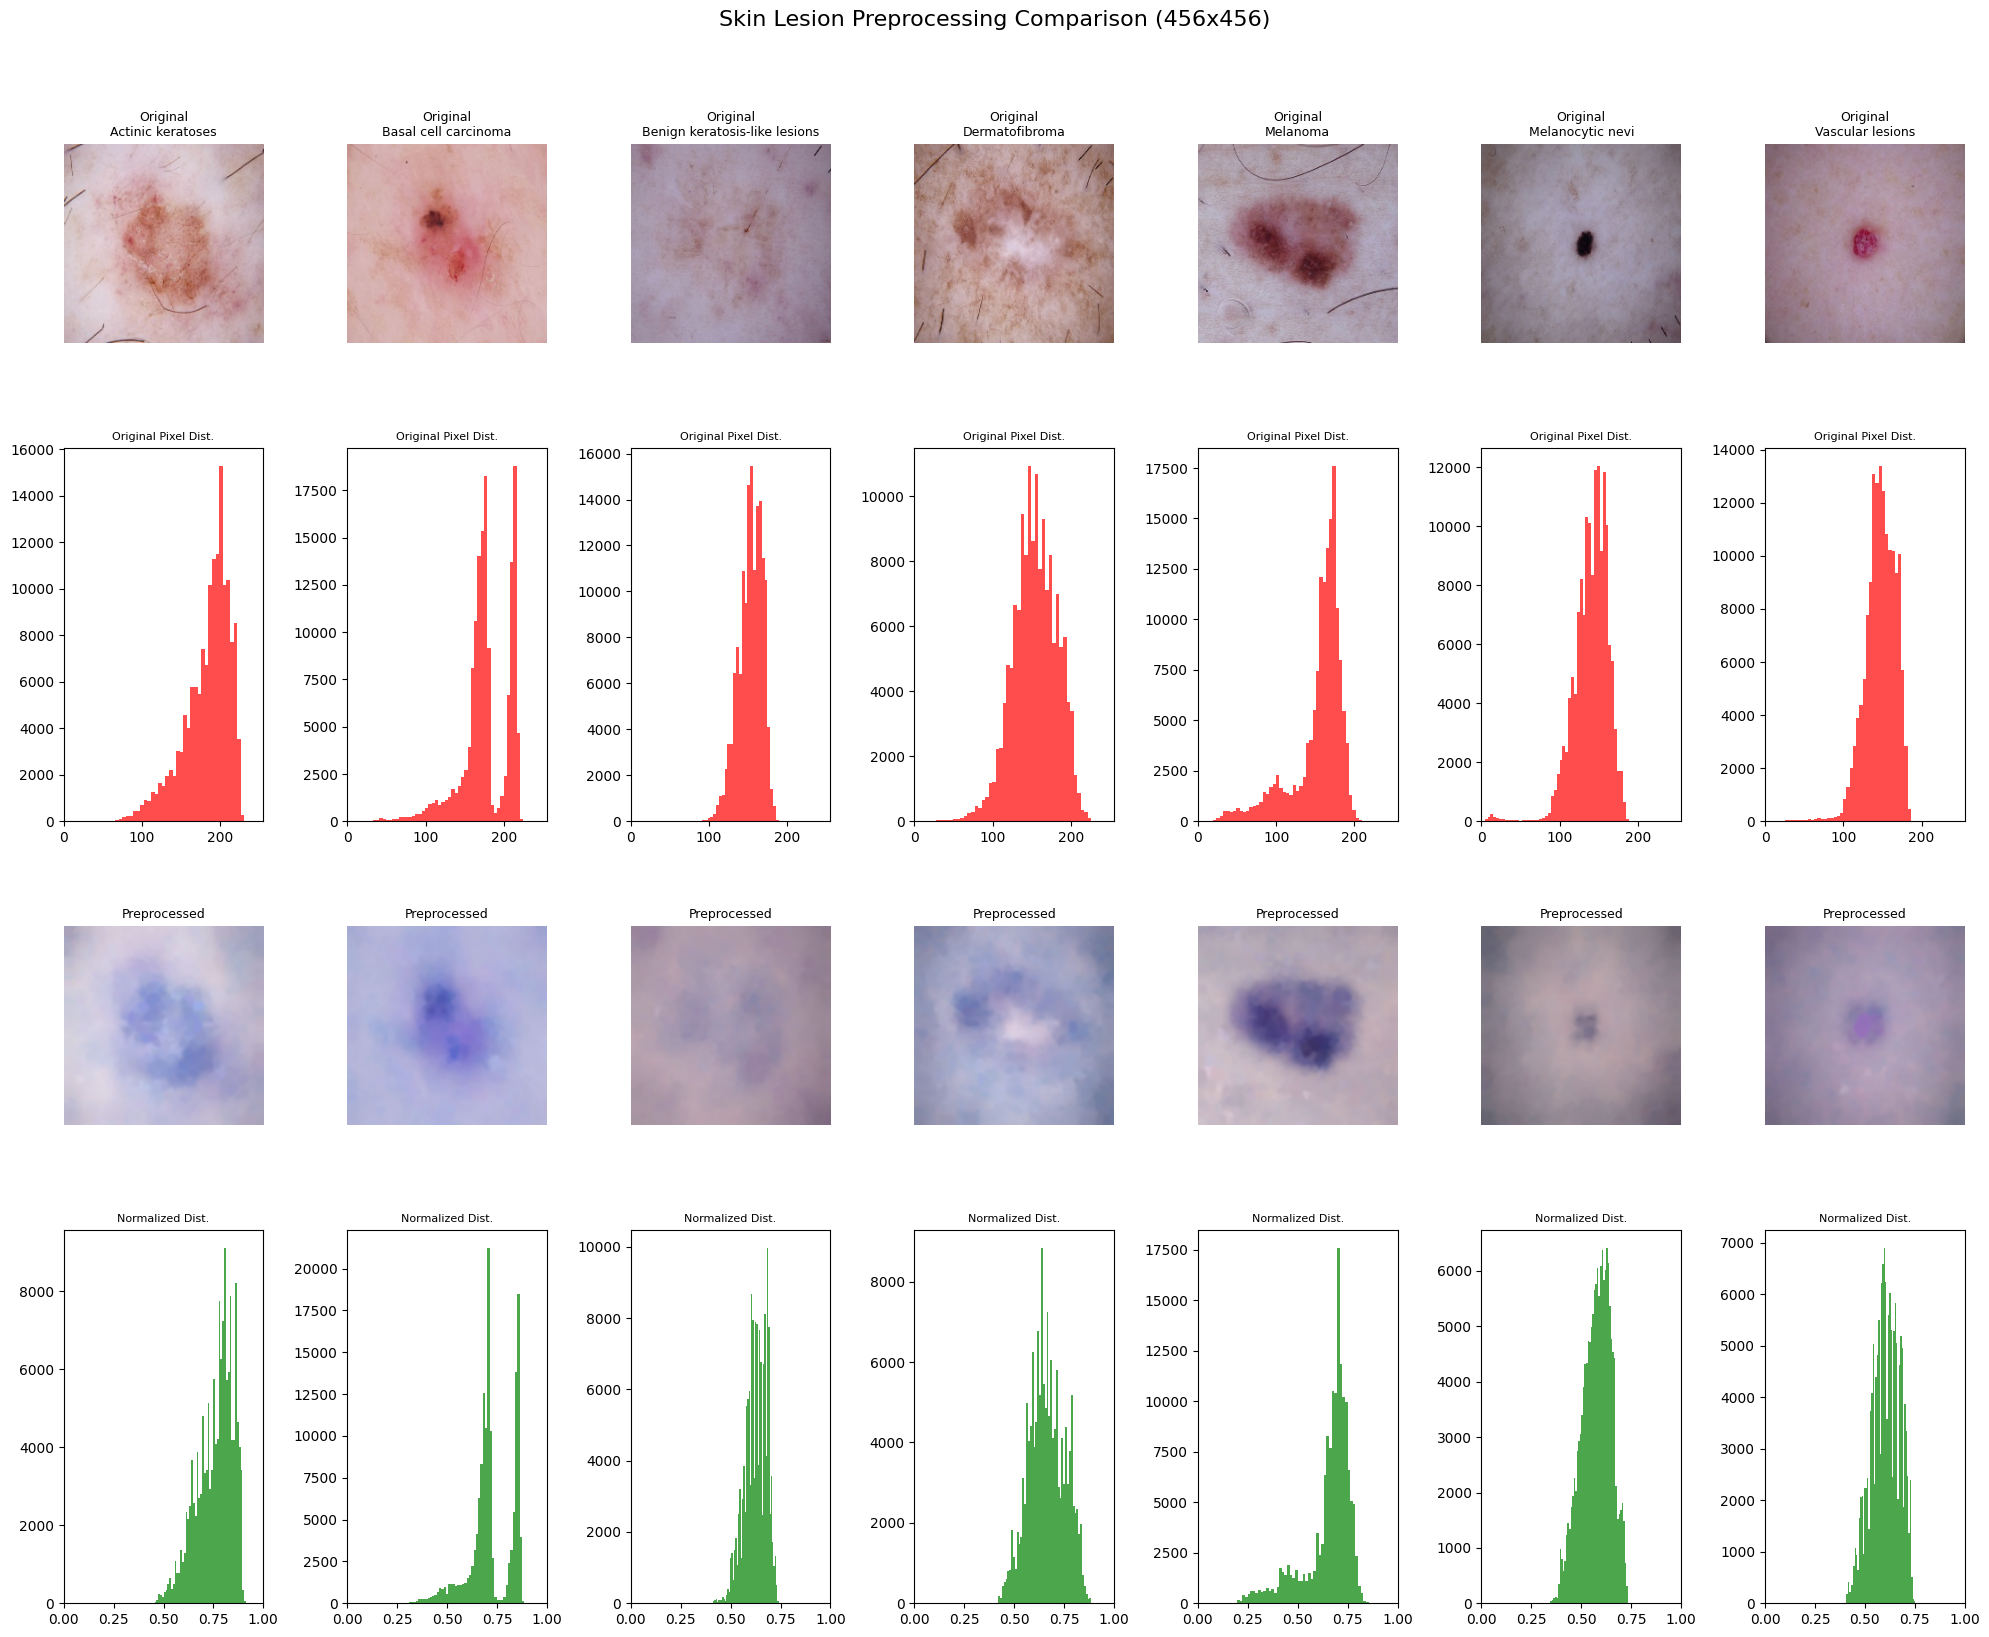

In [5]:
# ✅ Image preprocessing function
def preprocess_image(image_path, IMAGE_SIZE=224):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    
    inpainted = cv2.inpaint(img, blackhat, 1, cv2.INPAINT_TELEA)
    denoised = cv2.GaussianBlur(inpainted, (7, 7), 0)
    
    normalized = denoised.astype('float32') / 255.0
    return normalized

# ✅ Get one sample image path per class
sample_paths = []
for class_code in sorted(lesion_type_dict.keys()):
    class_folder = os.path.join(base_skin_dir, class_code)  # <-- Fixed this line
    image_files = os.listdir(class_folder)
    if image_files:
        sample_paths.append({
            'path': os.path.join(class_folder, image_files[0]),
            'label': lesion_type_dict[class_code]
        })

# ✅ Plot original vs preprocessed + histograms
plt.figure(figsize=(20, 16))

for i, sample in enumerate(sample_paths, 1):
    original = cv2.imread(sample['path'])
    original = cv2.resize(original, (224, 224))
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

    processed = preprocess_image(sample['path'])

    # Original image
    plt.subplot(4, 7, i)
    plt.imshow(original_rgb)
    plt.title(f"Original\n{sample['label']}", fontsize=9)
    plt.axis('off')

    # Histogram of original
    plt.subplot(4, 7, i + 7)
    plt.hist(original_rgb.ravel(), bins=50, color='red', alpha=0.7)
    plt.title("Original Pixel Dist.", fontsize=8)
    plt.xlim(0, 255)

    # Preprocessed image
    plt.subplot(4, 7, i + 14)
    plt.imshow((processed * 255).astype('uint8'))
    plt.title("Preprocessed", fontsize=9)
    plt.axis('off')

    # Histogram of preprocessed
    plt.subplot(4, 7, i + 21)
    plt.hist(processed.ravel(), bins=50, color='green', alpha=0.7)
    plt.title("Normalized Dist.", fontsize=8)
    plt.xlim(0, 1)

plt.tight_layout()
plt.suptitle("Skin Lesion Preprocessing Comparison (456x456)", y=1.02, fontsize=16)
plt.show()

In [6]:

# Generate lists for tabular data
image_paths = []
class_codes = []
class_labels = []

# Collect data from folders
for class_code in sorted(lesion_type_dict.keys()):
    class_dir = os.path.join(dataset_path, class_code)
    for fname in os.listdir(class_dir):
        if fname.endswith('.jpg'):
            image_paths.append(os.path.join(class_dir, fname))
            class_codes.append(class_code)
            class_labels.append(lesion_type_dict[class_code])

# Create tabular DataFrame
tabular_data = pd.DataFrame({
    'image_path': image_paths,
    'class_code': class_codes,
    'class_label': class_labels
})
tabular_data.head()

image_path class_code  \
0  /kaggle/input/ham10000-dataset/HAM10000_folder...      akiec   
1  /kaggle/input/ham10000-dataset/HAM10000_folder...      akiec   
2  /kaggle/input/ham10000-dataset/HAM10000_folder...      akiec   
3  /kaggle/input/ham10000-dataset/HAM10000_folder...      akiec   
4  /kaggle/input/ham10000-dataset/HAM10000_folder...      akiec   

         class_label  
0  Actinic keratoses  
1  Actinic keratoses  
2  Actinic keratoses  
3  Actinic keratoses  
4  Actinic keratoses

# **Exploratory Data Analysis (EDA)**

In [7]:
print(tabular_data.columns.tolist())


['image_path', 'class_code', 'class_label']


In [8]:
classes = {
    0: ('akiec', 'Actinic keratoses and intraepithelial carcinoma'),
    1: ('bcc', 'Basal cell carcinoma'),
    2: ('bkl', 'Benign keratosis-like lesions'),
    3: ('df', 'Dermatofibroma'),
    4: ('nv', 'Melanocytic nevi'),
    5: ('vasc', 'Vascular lesions (e.g., pyogenic granulomas, hemorrhage)'),
    6: ('mel', 'Melanoma')
}


# **Frequency Distribution of Classes**

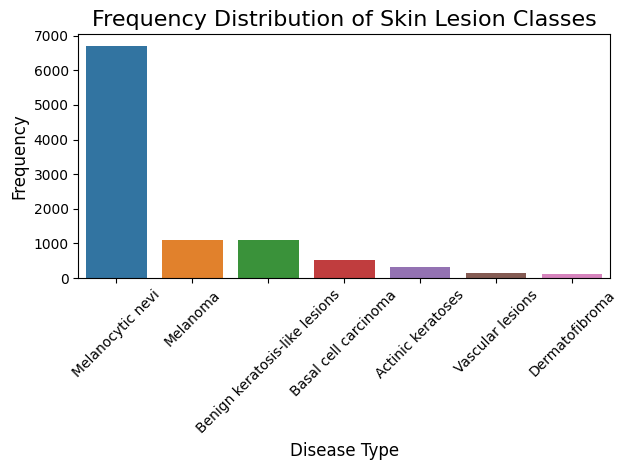

In [9]:
sns.countplot(x='class_label', data=tabular_data, order=tabular_data['class_label'].value_counts().index)
plt.xlabel('Disease Type', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Frequency Distribution of Skin Lesion Classes', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **Data Splitting**

In [10]:
from sklearn.model_selection import train_test_split

# Inputs
X = tabular_data['image_path'].values
y = tabular_data['class_code'].values  # or use 'class_label' for full names

# 1. Split into 70% train, 30% temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 2. Split temp into 10% val and 20% test (from original data)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=2/3, stratify=y_temp, random_state=42
)

# Print split sizes
print(f"Train size: {len(X_train)} ({len(X_train)/len(X):.2%})")
print(f"Validation size: {len(X_val)} ({len(X_val)/len(X):.2%})")
print(f"Test size: {len(X_test)} ({len(X_test)/len(X):.2%})")


Train size: 7010 (70.00%)
Validation size: 1001 (10.00%)
Test size: 2004 (20.01%)


# **Combine into DataFrames**

In [11]:
# Create DataFrames from the splits
train_df = pd.DataFrame({'image_path': X_train, 'class_code': y_train})
val_df = pd.DataFrame({'image_path': X_val, 'class_code': y_val})
test_df = pd.DataFrame({'image_path': X_test, 'class_code': y_test})

# Ensure class labels are strings (important for generators or classification reports)
train_df['class_code'] = train_df['class_code'].astype(str)
val_df['class_code'] = val_df['class_code'].astype(str)
test_df['class_code'] = test_df['class_code'].astype(str)


# **Augmentation**

In [12]:
class_counts = train_df['class_code'].value_counts()
max_count = class_counts.max()
print("Original class distribution:\n", class_counts)


Original class distribution:
 class_code
nv       4693
mel       779
bkl       769
bcc       360
akiec     229
vasc       99
df         81
Name: count, dtype: int64


In [13]:
augmented_dir = "/kaggle/working/augmented_dataset"
os.makedirs(augmented_dir, exist_ok=True)

In [14]:
import os
import uuid
import shutil
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

# Constants
IMAGE_SIZE = 224
augmented_dir = "/kaggle/working/augmented_dataset"
os.makedirs(augmented_dir, exist_ok=True)

# Step 1: Count class samples
class_counts = train_df['class_code'].value_counts()
max_count = class_counts.max()
majority_class = class_counts.idxmax()

print(f" Majority class is: '{majority_class}' with {max_count} samples.\n")

# Step 2: Create folders & copy original images
for label in train_df['class_code'].unique():
    class_folder = os.path.join(augmented_dir, label)
    os.makedirs(class_folder, exist_ok=True)

    # Copy original images
    class_df = train_df[train_df['class_code'] == label]
    for _, row in class_df.iterrows():
        src = row['image_path']
        dst = os.path.join(class_folder, os.path.basename(src))
        if not os.path.exists(dst):
            shutil.copy(src, dst)

# Step 3: Set up augmentation generator
augmenter = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Step 4: Augment only minority classes
augmented_records = []

for label in class_counts.index:
    if label == majority_class:
        print(f"Skipping augmentation for majority class '{label}'.\n")
        continue

    class_df = train_df[train_df['class_code'] == label]
    current_count = len(class_df)
    n_needed = max_count - current_count

    print(f" Augmenting class '{label}' with {n_needed} images...")

    class_folder = os.path.join(augmented_dir, label)
    generated = 0

    while generated < n_needed:
        for _, row in class_df.iterrows():
            img = load_img(row['image_path'], target_size=(IMAGE_SIZE, IMAGE_SIZE))
            x = img_to_array(img).reshape((1,) + (IMAGE_SIZE, IMAGE_SIZE, 3))

            for batch in augmenter.flow(x, batch_size=1):
                out_filename = f"{uuid.uuid4().hex}.jpg"
                out_path = os.path.join(class_folder, out_filename)
                array_to_img(batch[0]).save(out_path)

                augmented_records.append({'image_path': out_path, 'class_code': label})
                generated += 1
                break  # Only one image per original input

            if generated >= n_needed:
                break

print(" Augmentation completed.")


 Majority class is: 'nv' with 4693 samples.

Skipping augmentation for majority class 'nv'.

 Augmenting class 'mel' with 3914 images...
 Augmenting class 'bkl' with 3924 images...
 Augmenting class 'bcc' with 4333 images...
 Augmenting class 'akiec' with 4464 images...
 Augmenting class 'vasc' with 4594 images...
 Augmenting class 'df' with 4612 images...
 Augmentation completed.


In [15]:
augmented_df = pd.DataFrame(augmented_records)
balanced_train_df = pd.concat([train_df, augmented_df], ignore_index=True)
balanced_train_df = balanced_train_df.sample(frac=1, random_state=42).reset_index(drop=True)

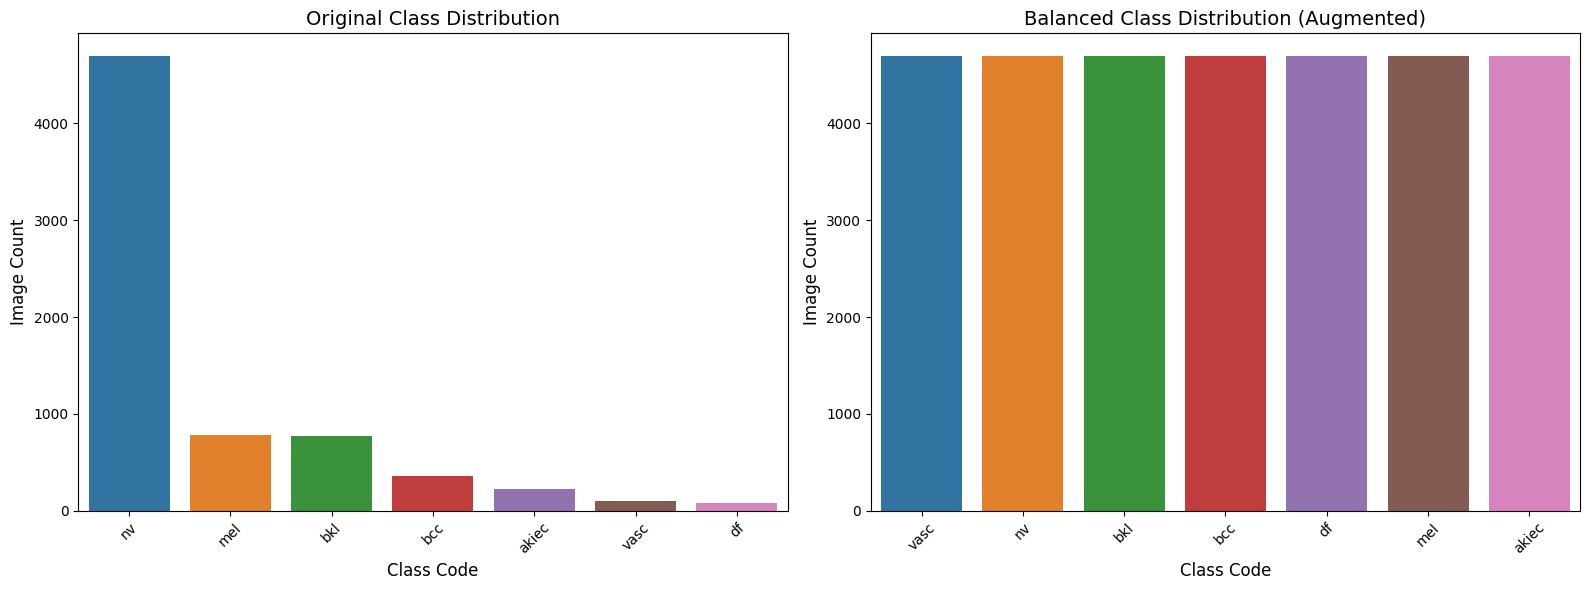

In [16]:
plt.figure(figsize=(16, 6))

# --- Plot 1: Original Data Distribution ---
plt.subplot(1, 2, 1)
sns.countplot(data=train_df, x='class_code', order=train_df['class_code'].value_counts().index)
plt.title("Original Class Distribution", fontsize=14)
plt.xlabel("Class Code", fontsize=12)
plt.ylabel("Image Count", fontsize=12)
plt.xticks(rotation=45)

# --- Plot 2: Balanced Data Distribution ---
plt.subplot(1, 2, 2)
sns.countplot(data=balanced_train_df, x='class_code', order=balanced_train_df['class_code'].value_counts().index)
plt.title("Balanced Class Distribution (Augmented)", fontsize=14)
plt.xlabel("Class Code", fontsize=12)
plt.ylabel("Image Count", fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# **One-hot encode the labels And Data Generators (for categorical classification)**

In [17]:
# Ensure labels are strings
balanced_train_df['class_code'] = balanced_train_df['class_code'].astype(str)
val_df['class_code'] = val_df['class_code'].astype(str)
test_df['class_code'] = test_df['class_code'].astype(str)

# Constants
IMAGE_SIZE = 224
BATCH_SIZE = 32
seed = 42

# Data generators
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

# Train generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=balanced_train_df,
    x_col='image_path',
    y_col='class_code',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=seed
)

# Validation generator
val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='class_code',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=seed
)

# Test generator
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='class_code',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
    seed=seed
)

# Print dataset info
print("Train classes:", train_generator.class_indices)
print("Train samples:", train_generator.samples)
print("Validation samples:", val_generator.samples)
print("Test samples:", test_generator.samples)

Found 32851 validated image filenames belonging to 7 classes.
Found 1001 validated image filenames belonging to 7 classes.
Found 2004 validated image filenames belonging to 7 classes.
Train classes: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
Train samples: 32851
Validation samples: 1001
Test samples: 2004


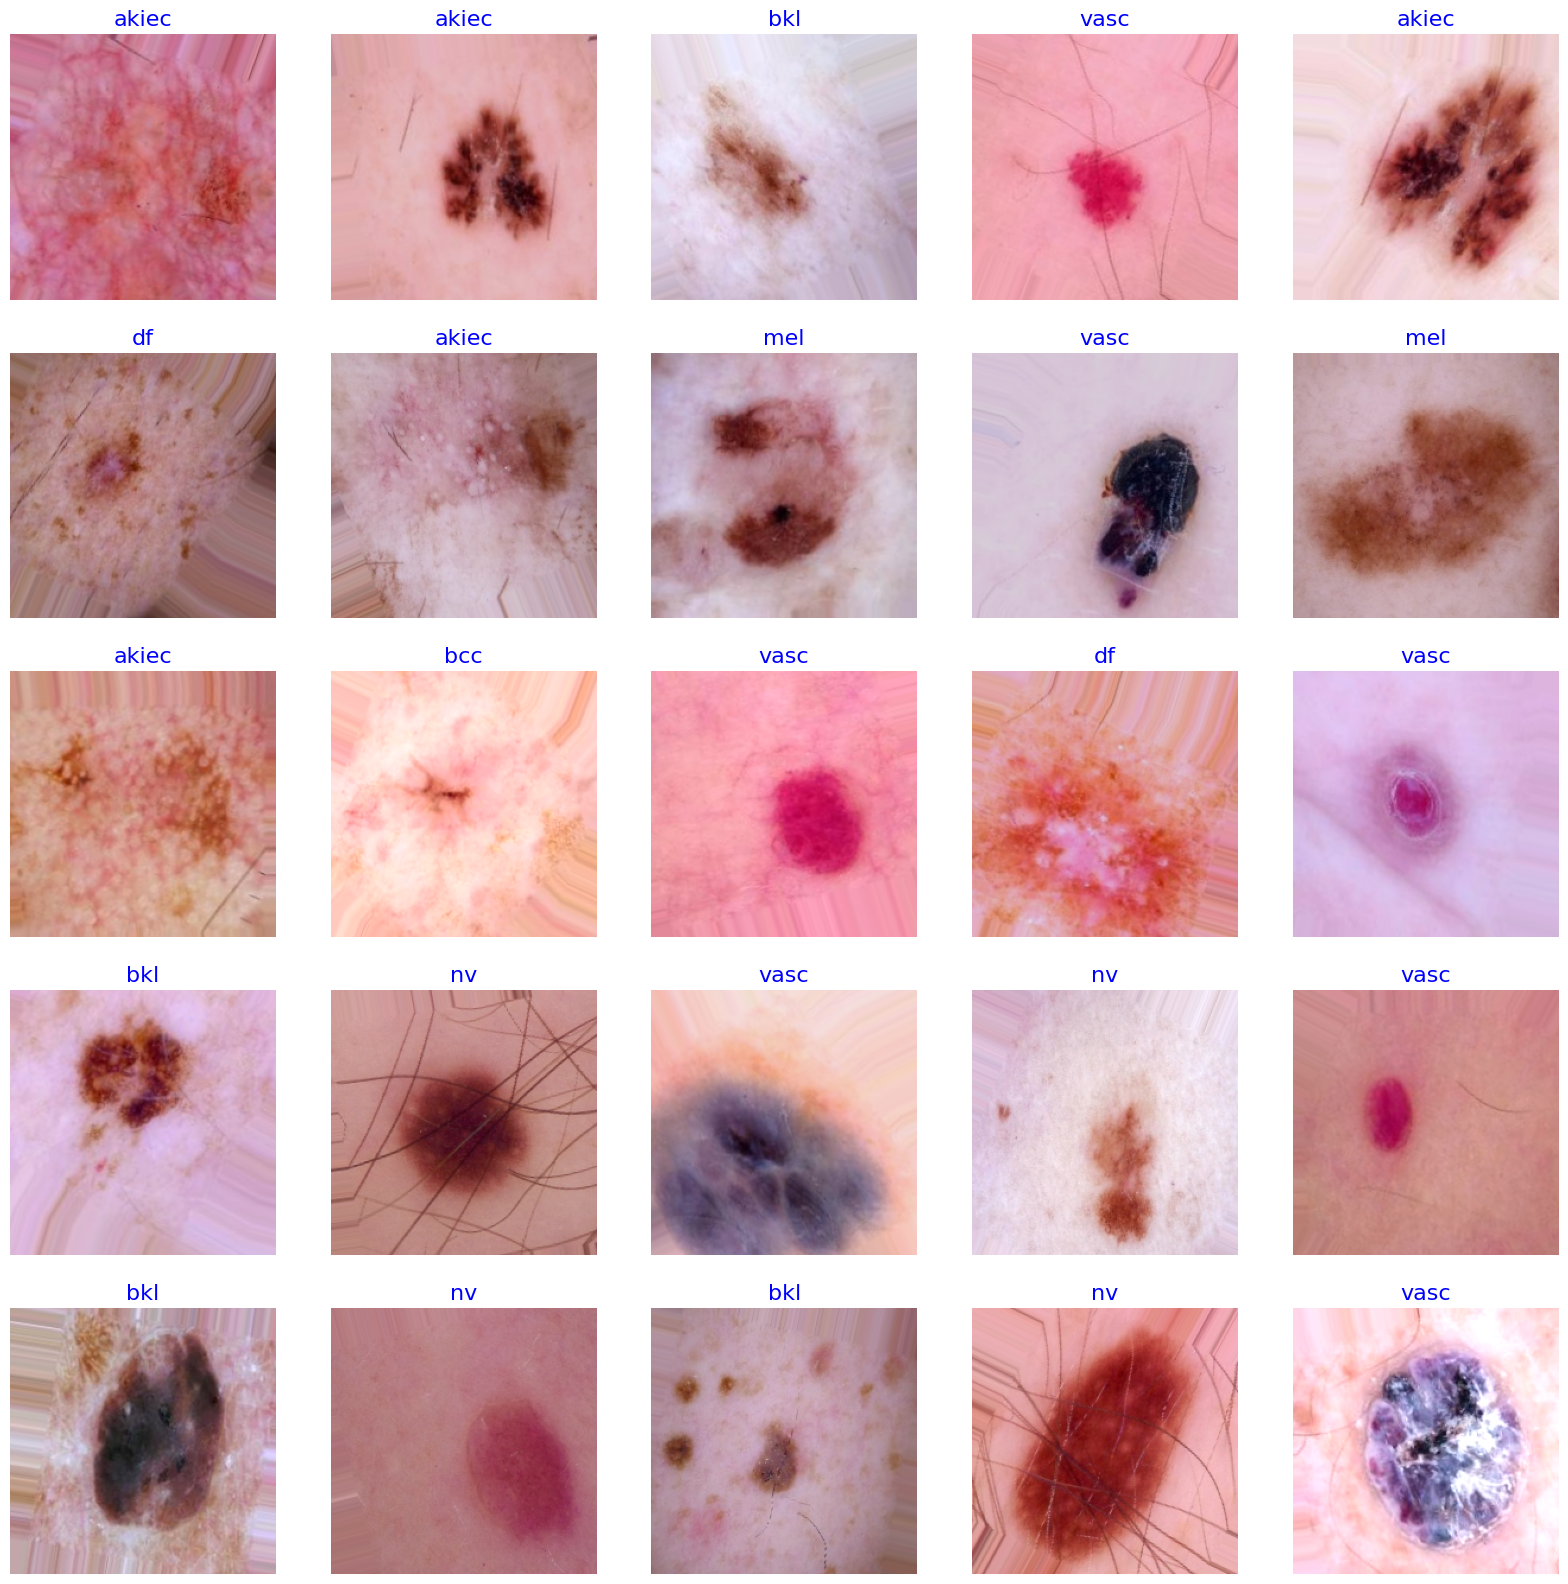

In [18]:
def show_image_samples(gen ):
    test_dict=test_generator.class_indices
    classes=list(test_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]/255 # scale images between 0 and 1 becaue no preprocessing scaling was done for efficientnet
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

show_image_samples(train_generator)

# **Build and compile the EfficientNetB5 model**

In [35]:
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense ,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define image size for EfficientNetB5
IMAGE_SIZE = 224  
BATCH_SIZE = 16
num_classes = 7
# Load EfficientNetB5 without top layer
base_model = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_model.trainable = False
for layer in base_model.layers:
    if layer.name == 'block6a_expand_conv':
        layer.trainable = True
    
# Custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)

x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)

x = Dropout(0.2)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 224, 224, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 48)   │          1,296 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 29,073,406 (110.91 MB)

 Trainable params: 744,967 (2.84 MB)

 Non-trainable params: 28,328,439 (108.06 MB)

# **Train the model**

In [36]:
import warnings
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
warnings.filterwarnings("ignore")
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.3, min_lr=1e-6)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/15
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 526s 453ms/step - accuracy: 0.3539 - loss: 2.5571 - val_accuracy: 0.7293 - val_loss: 1.3798 - learning_rate: 1.0000e-04
Epoch 2/15
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 412s 398ms/step - accuracy: 0.5969 - loss: 1.7108 - val_accuracy: 0.7303 - val_loss: 1.3423 - learning_rate: 1.0000e-04
Epoch 3/15
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 410s 396ms/step - accuracy: 0.6860 - loss: 1.4360 - val_accuracy: 0.7612 - val_loss: 1.2160 - learning_rate: 1.0000e-04
Epoch 4/15
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 410s 397ms/step - accuracy: 0.7351 - loss: 1.2751 - val_accuracy: 0.7682 - val_loss: 1.1558 - learning_rate: 1.0000e-04
Epoch 5/15
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 410s 397ms/step - accuracy: 0.7619 - loss: 1.1578 - val_accuracy: 0.7772 - val_loss: 1.1279 - learning_rate: 1.0000e-04
Epoch 6/15
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 409s 396ms/step - accuracy: 0.7967 - loss: 1.0401 - val_accuracy: 0.7882 - val_loss: 1.0430 - learning_rate: 1.0000e-04
Epoch 7/15
1027/1027 ━━━━━━━

In [50]:
best_epoch = np.argmax(history.history['accuracy']) + 1 
best_acc = history.history['accuracy'][best_epoch - 1]

print(f"Best Epoch: {best_epoch}")
print(f"Accuracy at Best Epoch: {best_acc:.4f}")

Best Epoch: 15
Accuracy at Best Epoch: 0.9084


In [44]:
import shutil

# Create directory to save model
save_dir = '/kaggle/working/my_model'
os.makedirs(save_dir, exist_ok=True)

# Save model as HDF5 file
model.save(os.path.join(save_dir, 'SpotCancerAI.h5'))

# Create a zip file of the directory
shutil.make_archive('/kaggle/working/Final_Model', 'zip', save_dir)


'/kaggle/working/Final_Model.zip'

# **Plot Training History (Accuracy & Loss)**

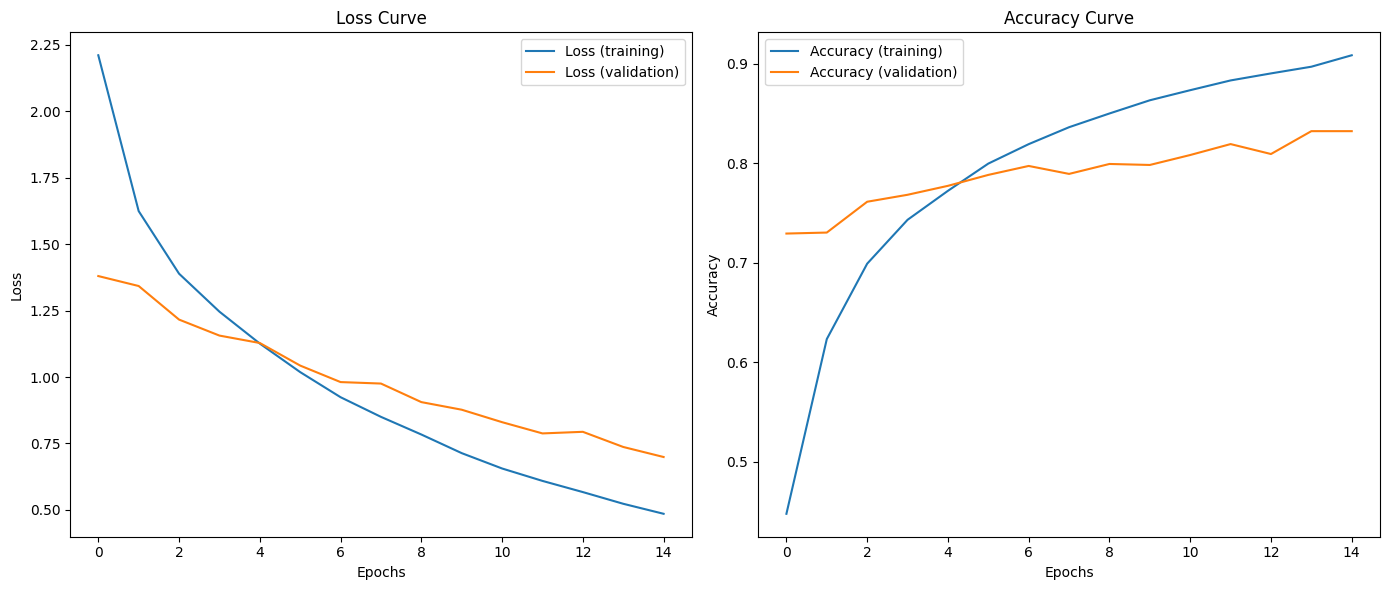

In [45]:
import matplotlib.pyplot as plt

# Training curve
plt.figure(figsize=(14, 6))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss (training)')
plt.plot(history.history['val_loss'], label='Loss (validation)')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy (training)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation)')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



# **Evaluate the Model on Test Data**

In [46]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

2004/2004 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.8355 - loss: 0.7577
Test Loss: 0.7360
Test Accuracy: 0.8343


# **Confusion Metrix**

2004/2004 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step
Classification Report:

              precision    recall  f1-score   support

       akiec       0.70      0.43      0.53        65
         bcc       0.79      0.62      0.70       103
         bkl       0.70      0.60      0.65       220
          df       1.00      0.55      0.71        22
         mel       0.66      0.52      0.59       223
          nv       0.88      0.97      0.92      1342
        vasc       0.95      0.72      0.82        29

    accuracy                           0.83      2004
   macro avg       0.81      0.63      0.70      2004
weighted avg       0.82      0.83      0.82      2004



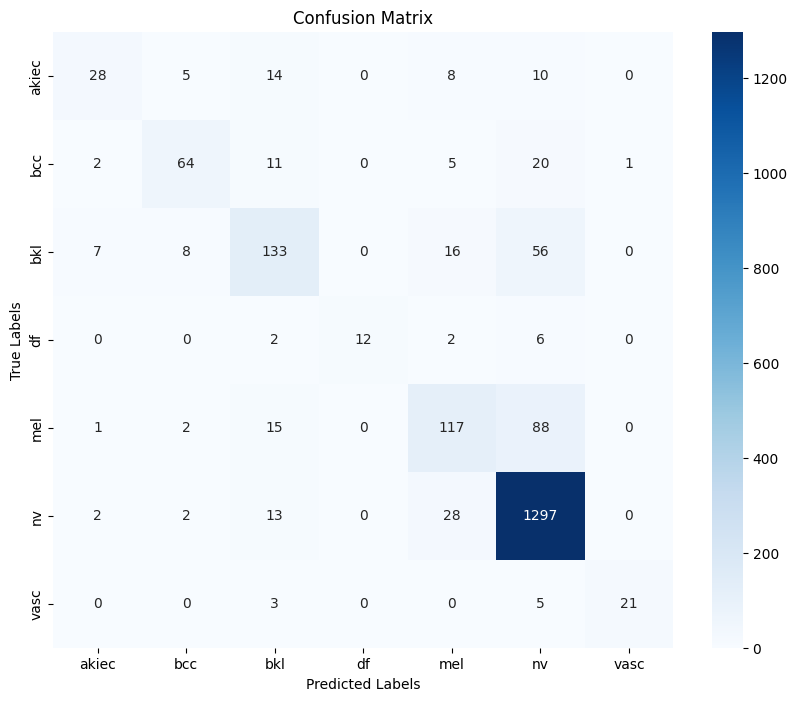

In [47]:
from sklearn.metrics import confusion_matrix, classification_report

# Step 1: Get predicted probabilities
y_prob = model.predict(test_generator)

# Step 2: Convert probabilities to predicted class indices
y_pred = np.argmax(y_prob, axis=1)

# Step 3: Get true labels from the generator
y_true = test_generator.classes

# Step 4: Get label names from generator
labels = list(test_generator.class_indices.keys())

# Step 5: Print Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels))

# Step 6: Plot Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow.keras.preprocessing import image

# Get filenames from the generator
file_paths = test_generator.filepaths
true_labels = test_generator.classes
pred_probs = model.predict(test_generator, verbose=1)
pred_labels = np.argmax(pred_probs, axis=1)

# Get label mapping
class_indices = test_generator.class_indices
idx_to_label = dict((v, k) for k, v in class_indices.items())

# Display 12 random predictions
plt.figure(figsize=(18, 12))
for i in range(12):
    index = random.randint(0, len(file_paths) - 1)

    # Load image
    img = image.load_img(file_paths[index], target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_array = image.img_to_array(img) / 255.0

    true_label = idx_to_label[true_labels[index]]
    pred_label = idx_to_label[pred_labels[index]]
    confidence = np.max(pred_probs[index])

    plt.subplot(3, 4, i + 1)
    plt.imshow(img_array)
    plt.axis('off')

    if true_label == pred_label:
        title_color = 'green'
        status = "✅"
    else:
        title_color = 'red'
        status = "❌"

    plt.title(f"{status} True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}", color=title_color)

plt.tight_layout()
plt.suptitle("Original vs Predicted Labels with Confidence", fontsize=16, y=1.02)
plt.show()

2004/2004 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step
